In [1]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..\\..'))
	print(os.getcwd())
except:
	pass


c:\Users\victo\OneDrive\Escritorio\Tesis


In [2]:
# Importando librerías necesarias para el análisis
import pandas as pd, numpy as np, seaborn as sns
import os
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [3]:
# Accesando al directorio de la data "../data"
os.chdir('C:/Users/victo/OneDrive/Escritorio/Tesis/Analisis/data')


In [4]:
# Configurando de las visualizaciones
plt.style.use('seaborn')


In [5]:
# Importando data para análisis fisicoquímico
fq = pd.read_csv('fisicoquimica.csv')


In [6]:
# Visualizar la estructura de los datos
fq.head()


,Punto,DBO,DBQ,Fosforo,Nitrogeno,Oxigeno,Turbidez,Coliformes,Zona
0,A,36.11,65,1,4.4,95.60,4.96,800,Urbano
1,A,37.88,67,1,5.5,98.13,4.96,5000,Urbano
2,A,38.88,70,1,3.3,95.90,3.95,6000,Urbano
3,B,43.52,74,1,0.7,99.20,4.40,6300,Urbano
4,B,45.88,78,1,1.5,99.20,5.63,7000,Urbano


In [7]:
# La distribución del fósforo es uniforme, no es de interés para clústering.
fq = fq.drop(['Fosforo'], axis=1) #Eliminar fósforo por distribución uniforme.


C:\Users\victo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\victo\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


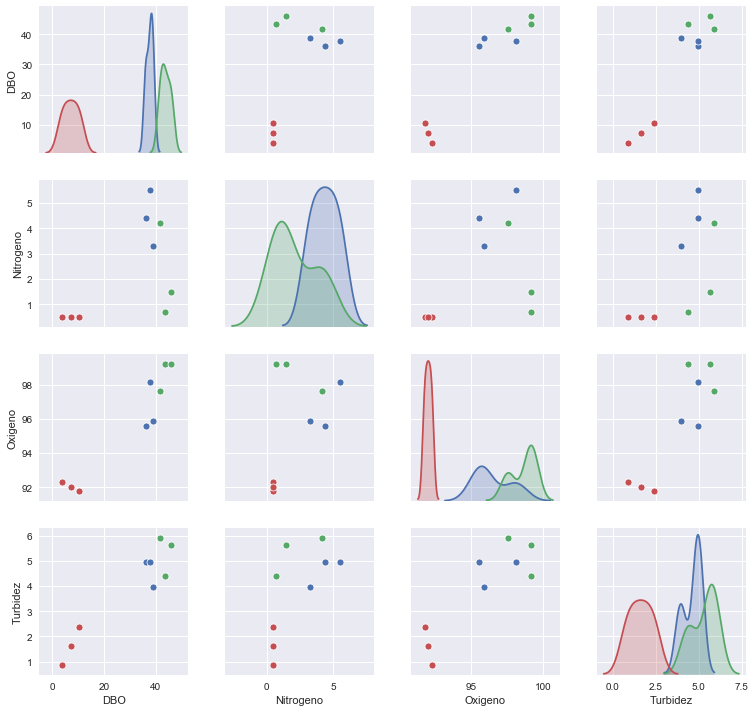

In [8]:
#Visualización de los datos en diagramas de dispersion por pares
fq_pairplot = fq[['Punto', 'DBO', 'Nitrogeno', 'Oxigeno', 'Turbidez']]
g =sns.pairplot(fq_pairplot, hue='Punto')
g._legend.remove()
plt.gcf()
plt.tight_layout()


In [9]:
# Definir una función para estandarización de los datos
transformer = StandardScaler()

# Columnas para estandarizar:
datos_numericos = ['DBO', 'DBQ', 'Nitrogeno', 'Oxigeno', 'Turbidez', 'Coliformes']
transformed_data = transformer.fit_transform(fq[datos_numericos])


C:\Users\victo\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\victo\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


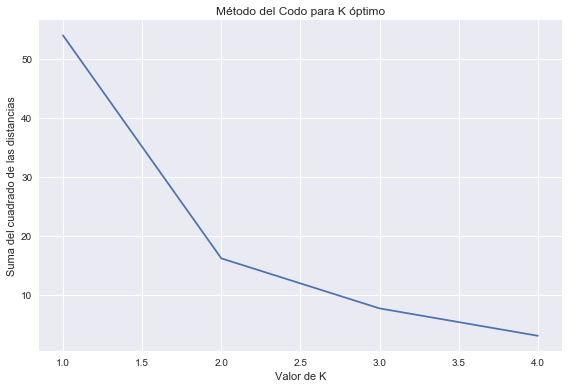

<Figure size 576x396 with 0 Axes>

In [10]:
# Determinación del mejor K para el clustering

def Determine_K(transformed_data, max):
    Sum_of_squared_distances = []
    K = range(1, max)
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(transformed_data)
        Sum_of_squared_distances.append(km.inertia_)
    
    plt.plot(K, Sum_of_squared_distances)
    plt.xlabel('Valor de K')
    plt.ylabel('Suma del cuadrado de las distancias')
    plt.title('Método del Codo para K óptimo')
    plt.tight_layout()
    return plt.show()

elbow_graph = Determine_K(transformed_data, 5)
plt.savefig(
    '../graficos/metodo del codo.png',
    transparent=True,
    dpi=300)



In [11]:
# Análisis KMeans para clasificación de Clústeres 
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k).fit(transformed_data)
labels = ([(x, y) for x, y in zip(fq['Punto'], kmeans.labels_)])
for label in labels:
    print(f"El punto {label[0]} fue clasificado como {label[1]}")


El punto A fue clasificado como 0
El punto A fue clasificado como 0
El punto A fue clasificado como 0
El punto B fue clasificado como 0
El punto B fue clasificado como 0
El punto B fue clasificado como 0
El punto C fue clasificado como 1
El punto C fue clasificado como 1
El punto C fue clasificado como 1


In [12]:
# Análisis de Componente Principal para visualización de clústeres
pca = PCA(n_components=2)
fq_pca_components = pca.fit_transform(transformed_data)
explained_variance = pca.explained_variance_ratio_
print(f"Varianza explicada: {sum(explained_variance)}")
pcaDF = pd.DataFrame(data=fq_pca_components,
    columns=['PC1', 'PC2'])

pcaVarDF = pd.DataFrame(pca.components_,
    columns=fq[datos_numericos].columns,
    index = ['PC1', 'PC2'])


Varianza explicada: 0.938270279322777


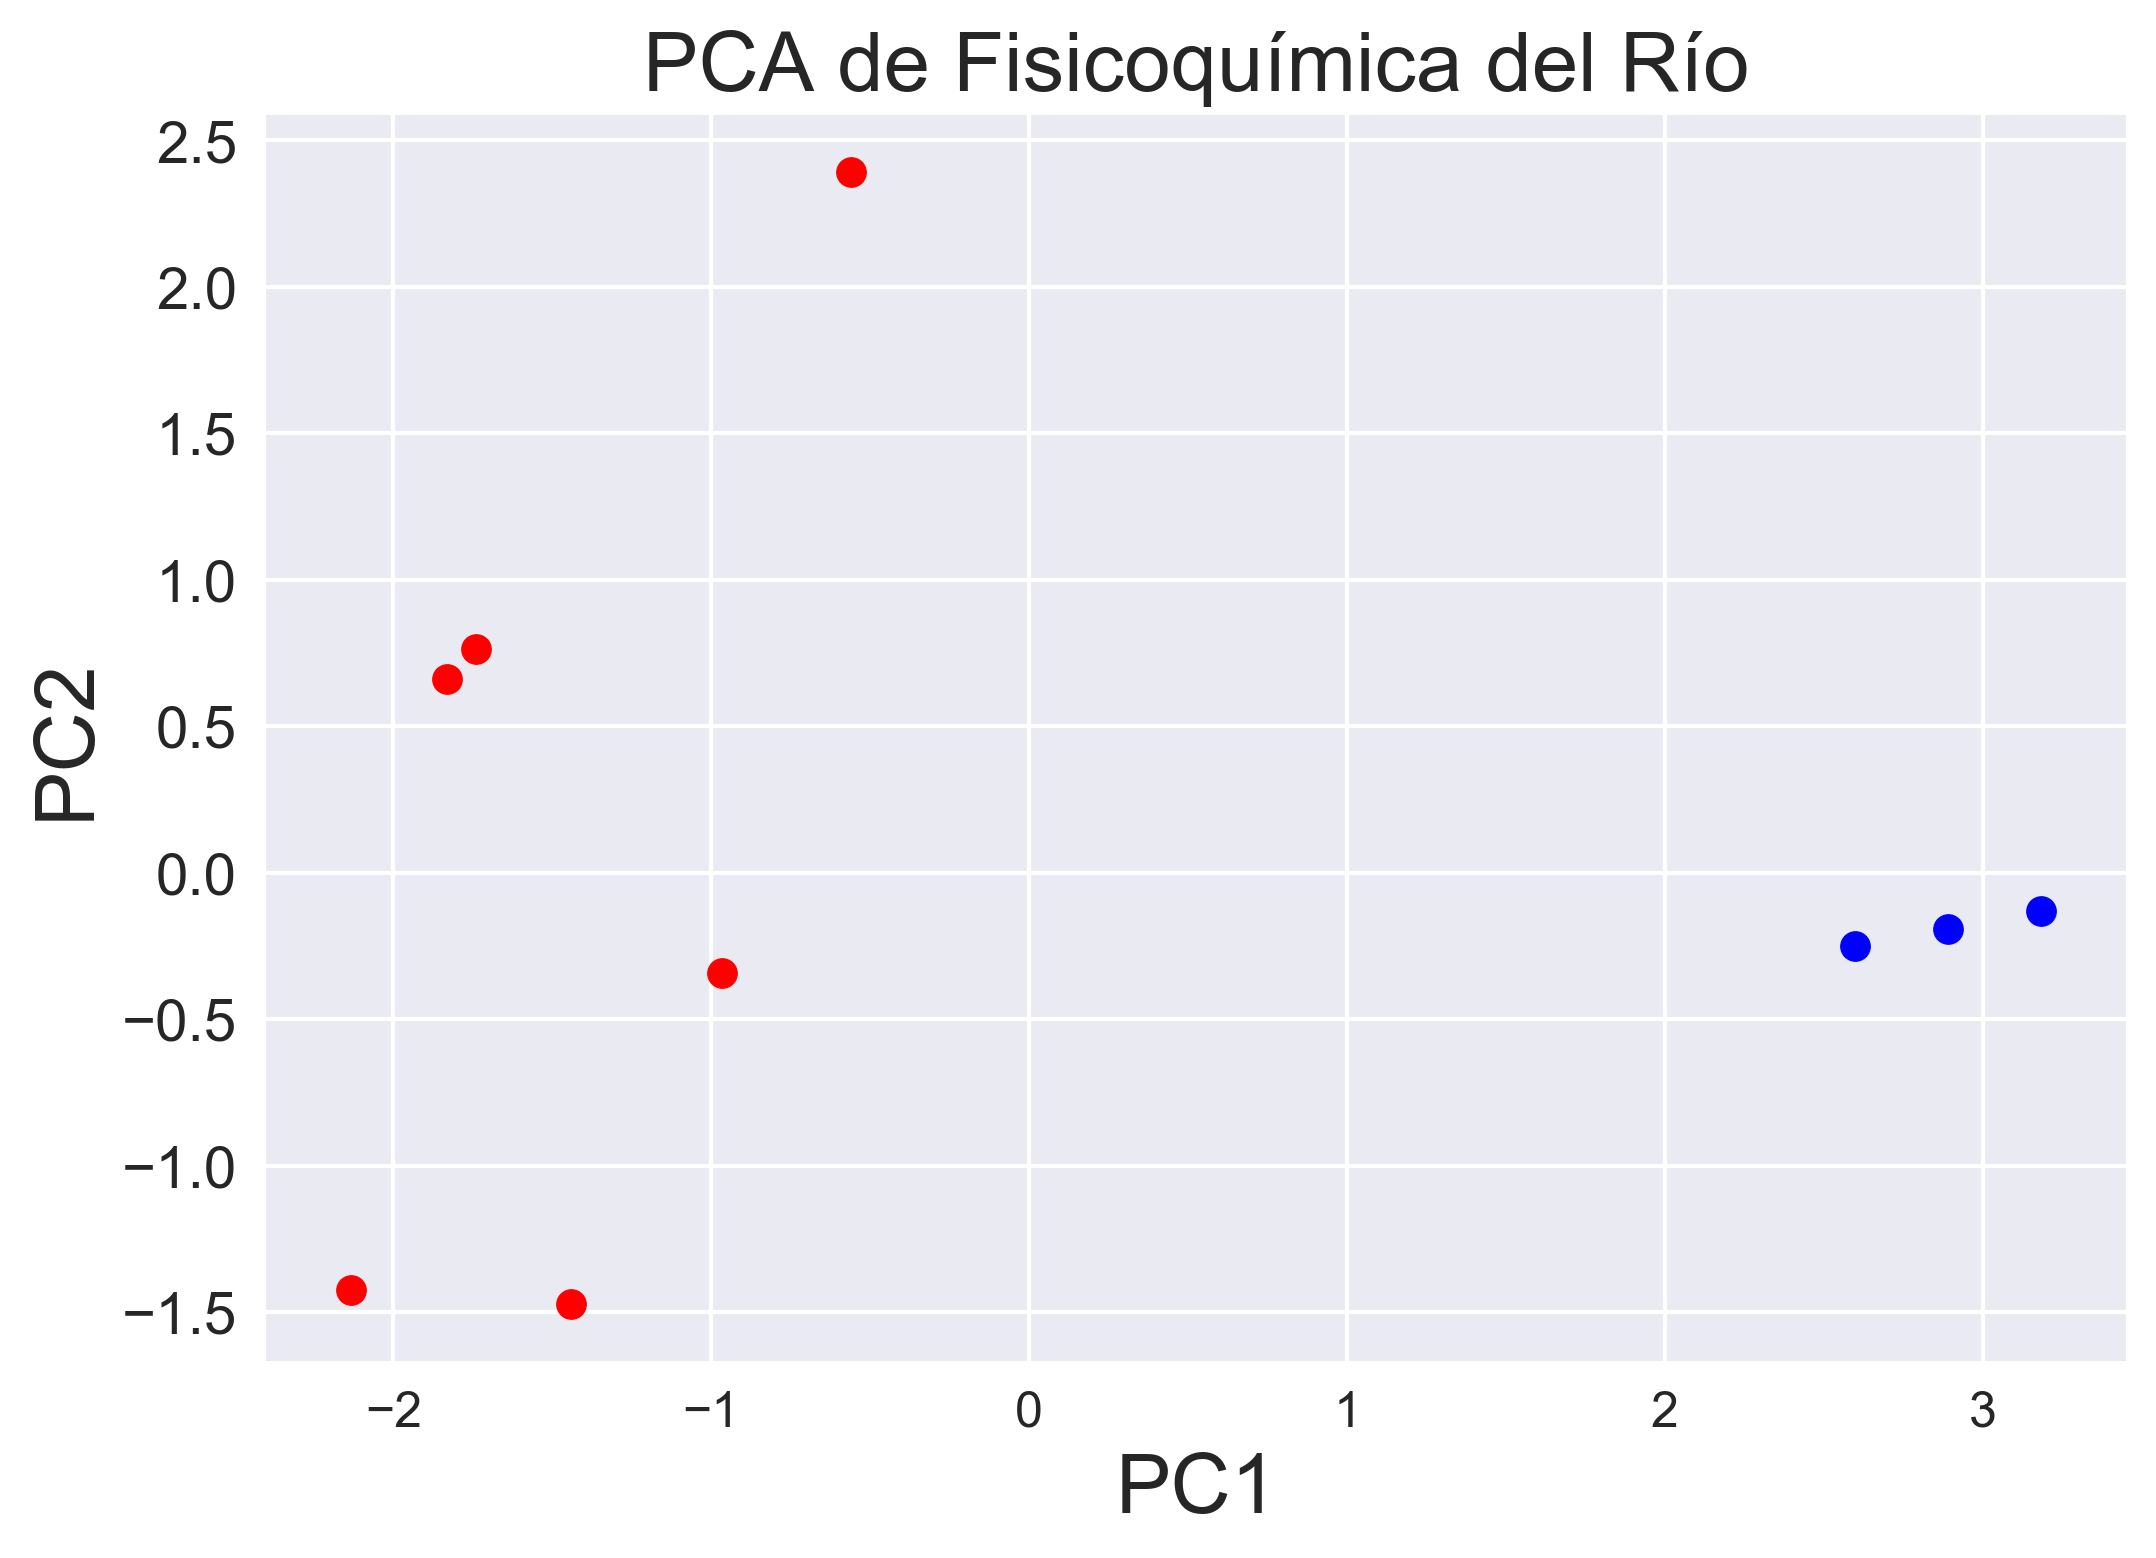

In [13]:
# Visualización del PCA
plt.figure(dpi=300)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('PC1', fontsize=20)
plt.ylabel('PC2', fontsize=20)
plt.title("PCA de Fisicoquímica del Río", fontsize=20)
targets = ['Rural', 'Urbano']
colors = ['b', 'r']
for target, color in zip(targets, colors):
    indices = fq['Zona'] == target
    plt.scatter(pcaDF.loc[indices, 'PC1']
               , pcaDF.loc[indices, 'PC2'], c = color, s = 50)

# plt.legend(targets, prop={'size': 15}, shadow=True, fancybox=True)


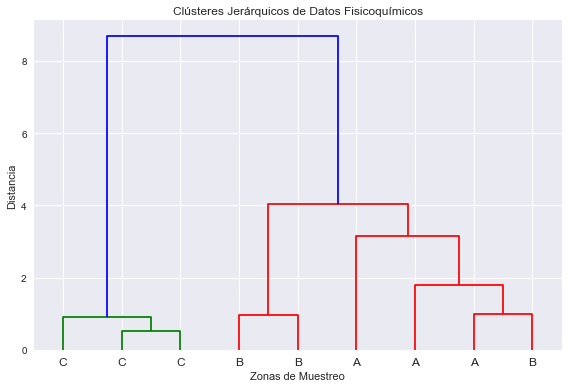

In [14]:
# Elaboración de Dendrograma
Z = linkage(transformed_data, 'ward')
dendog = dendrogram(
    Z,
    labels=['A', 'A', 'A', 'B', 'B', 'B', 'C', 'C', 'C']
    )
plt.gcf()
plt.title('Clústeres Jerárquicos de Datos Fisicoquímicos')
plt.xlabel('Zonas de Muestreo')
plt.ylabel('Distancia')
plt.savefig(
    '../graficos/dendograma_jerarquico.png',
    transparent=True,
    dpi=300
)
plt.tight_layout()
